<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_new_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



# Get Data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)

In [ ]:
from zipfile import ZipFile
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cp drive/My\ Drive/COVID-SemiSeg.zip /content/

In [5]:
with ZipFile('COVID-SemiSeg.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1m0u6Ic9ZoF-FS-_HRfIHKMdxNXztWLe7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ISIC2017')
with ZipFile('ISIC2017', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1TPLVTEzAgEcFFM2KJ5ijaCzW1oY6a_wX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('training_mask')
with ZipFile('training_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)

In [ ]:
os.remove("/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv")

# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [22]:
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg",".png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    img_mask = img_mask/255
    plt.imshow(img_mask,cmap='gray')
    img_mask[img_mask<0.5] = 0
    img_mask[img_mask>=0.5] = 1
    return img_mask


def build_data(path,mask_folder,csv_path,img_shapes):
  w,h = img_shapes
  imgs=[]
  masks=[]
  img_name=[]
  if csv_path == None:
    img_name = os.listdir(path)
  else:
    with open(csv_path, 'r') as csvFile:
      reader = csv.reader(csvFile)
      for row in reader:
          img_name.append(row[0])
  n = len(img_name)//20
  for count,file in enumerate(img_name[:]):
        if file.find("super")>0:
          continue
        fullpath= os.path.join(path,file)
        #print(fullpath)
        msk=get_mask(file,mask_folder)
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%n == 0:
          plt.figure(count//n)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          #plt.contour(msk,colors='r')
          #plt.draw()
          plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
          plt.show()  
  imgs=np.asarray(imgs,dtype=np.float)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks

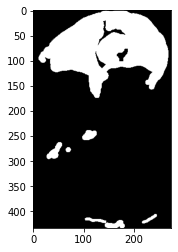

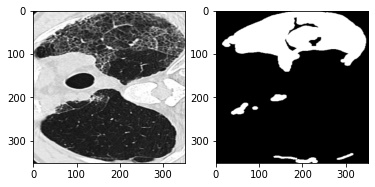

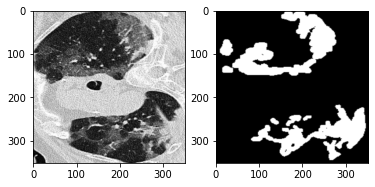

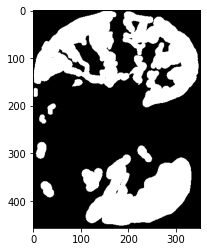

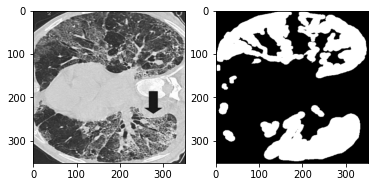

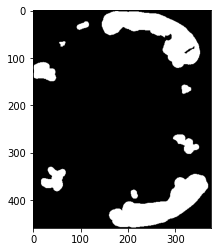

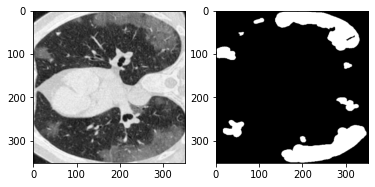

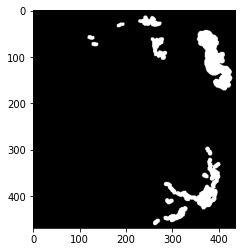

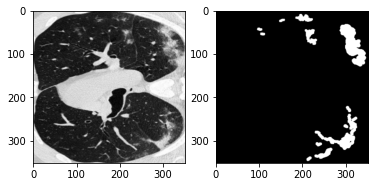

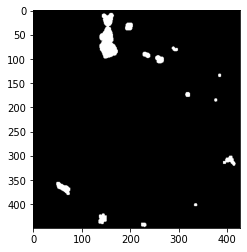

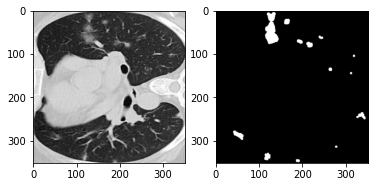

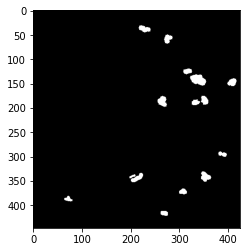

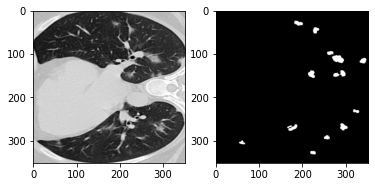

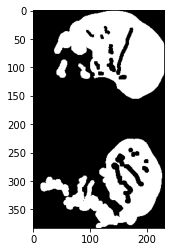

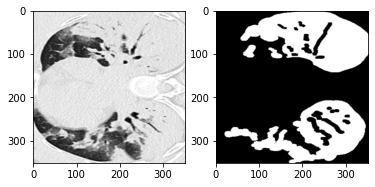

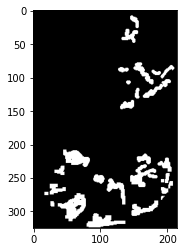

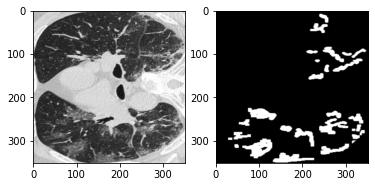

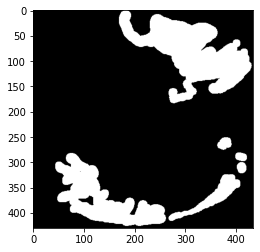

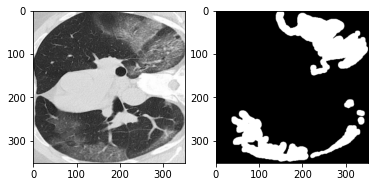

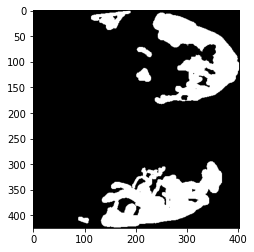

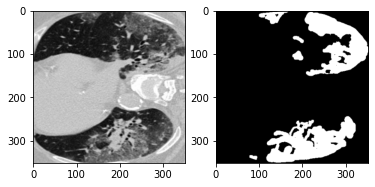

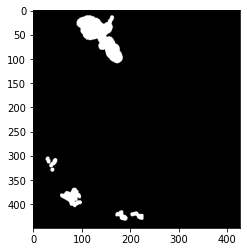

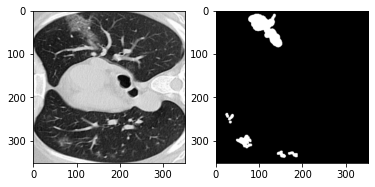

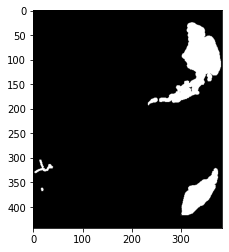

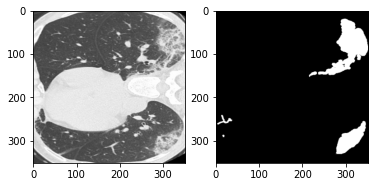

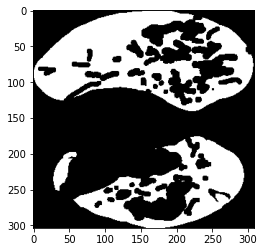

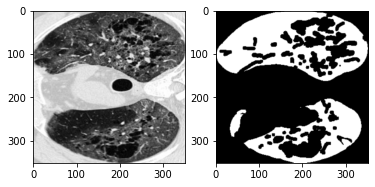

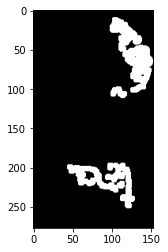

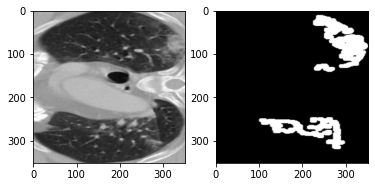

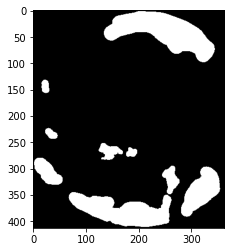

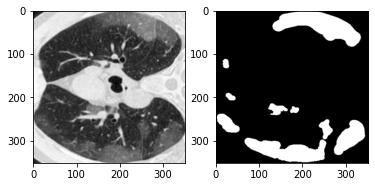

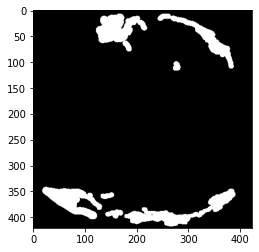

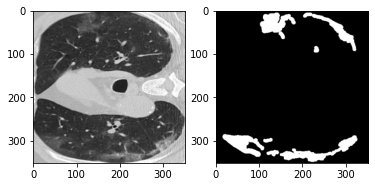

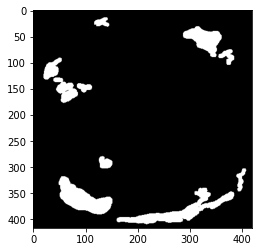

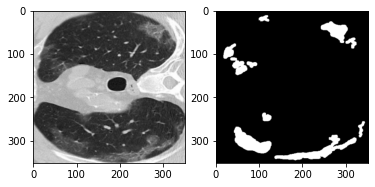

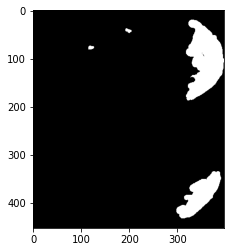

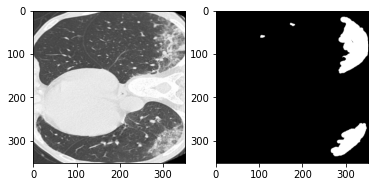

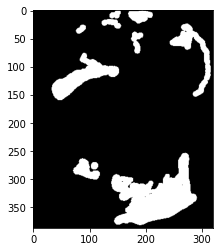

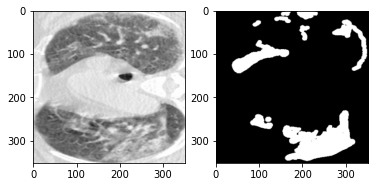

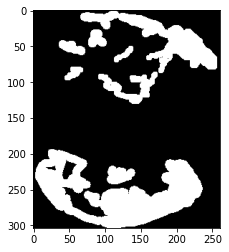

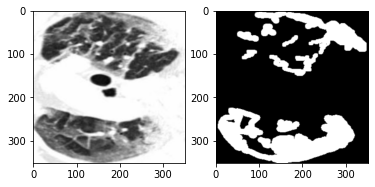

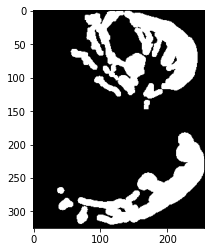

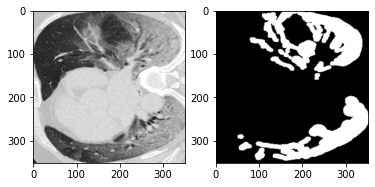

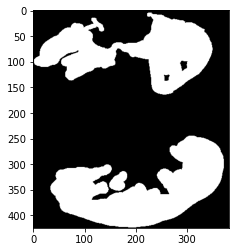

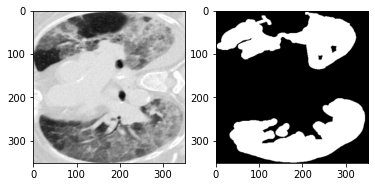

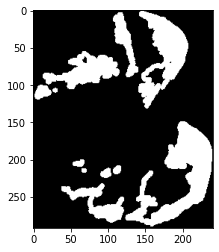

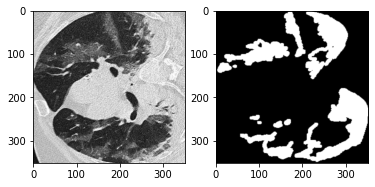

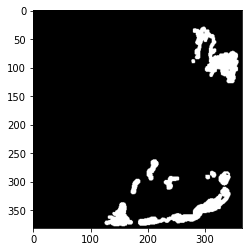

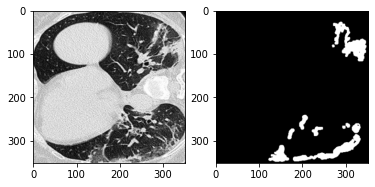

shape imgs:  (50, 352, 352, 3)
shape masks:  (50, 352, 352, 1)
---------------------------------------------------------


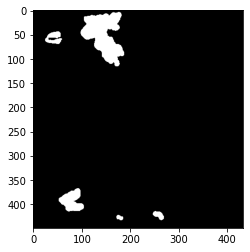

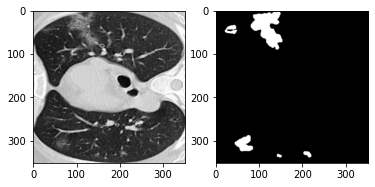

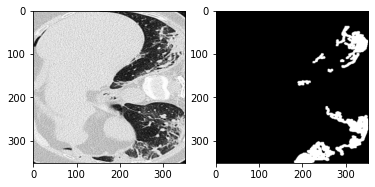

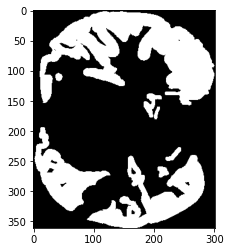

KeyboardInterrupt: ignored

In [23]:
w = 352
h = 352
folder_train = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Doctor-label/Imgs"
mask_train_folder = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Doctor-label/GT"
#csv_train = '/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv'
folder_test = "/content/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/Imgs"
mask_test_folder = "/content/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/GT"
# folder_train = "/content/ISIC-2017_Training_Data"
# mask_train_folder = "/content/ISIC-2017_Training_Part1_GroundTruth"
imgs,masks = build_data(folder_train,mask_train_folder, None, (w,h))
print("---------------------------------------------------------")
img_dev,mask_dev = build_data(folder_test,mask_test_folder, None, (w,h))



#loss

In [9]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=1.0):
    '''Average dice coefficient per batch.'''
    y_pred = heviside(y_pred,epsilon = 0.01)
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=1.0)
def gradientLoss2d(input):
    dH = K.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = K.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    dH = dH * dH
    dW = dW * dW
    loss = K.sum(dH) + K.sum(dW)
    return loss
def levelsetLoss(y_true, y_pred, ratio = 0.001):
    #print("go")
    outshape = y_pred.shape
    tarshape = y_true.shape
    multi = y_true*y_pred
    c_numerator = K.sum(multi, [1,2])
    c_denominator = K.sum(y_pred, [1,2])
    #print("outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape")
    #print(outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape)
    c = c_numerator/c_denominator
    #print("s",c.shape)
    c = K.reshape(c, (-1, 1, 1,outshape[3])) 
    #print("c.shape: ", c.shape)
    plevel = y_true - c
    #print("plevel: ", plevel)
    pLoss = plevel * plevel * y_pred
    lossL = K.mean(pLoss)
    #print("lossL: ", lossL)
    lossA = gradientLoss2d(y_pred) * ratio

    return lossL  + dice_coef_loss(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_pred = y_pred[0]
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
def heviside(x,epsilon=0.1):
    return 1/2*(1+2/3.14159*tf.math.atan(x/epsilon))
def Active_Contour_Loss(y_true, y_pred): 
    epison = 0.1
    Drc = (epison / 3.14159) / (epison * epison + y_pred[:,:,:,0] * y_pred[:,:,:,0])
    Hea = 1/2*(1+2/3.14159*tf.math.atan(y_pred[:,:,:,0]/0.1))
    #Hea = y_pred[:,:,:,0]
    """
    lenth term
    """

    x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] # horizontal and vertical directions 
    y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:]

    delta_x = x[:,1:,:-2,:]**2
    delta_y = y[:,:-2,:1,:]**2
    delta_u = K.abs(delta_x + delta_y) 

    lenth = K.mean(K.sqrt(delta_u + 0.00000001)) # equ.(11) in the paper

    """y_pred
    region term
    """

    C_1 = np.ones((h, w))
    C_2 = np.zeros((h, w))

    region_in = K.abs(K.mean( Hea * ((y_true[:,:,:,0] - C_1)**2) ) ) # equ.(12) in the paper
    region_out = K.abs(K.mean( (1-Hea) * ((y_true[:,:,:,0] - C_2)**2) )) # equ.(12) in the paper

    lambdaP = 1 # lambda parameter could be various.
    mu = 1 # mu parameter could be various.
    
    return lambdaP * (mu * region_in + 2*region_out) 






# Data Augument

In [10]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#attention gate

In [11]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

#callback

In [17]:
class lr_scheduler(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))


class visualize(tf.keras.callbacks.Callback):


    def __init__(self,img,mask):
        super(visualize, self).__init__()
        self.img = img
    def on_epoch_end(self, epoch, logs=None):
       feature_maps = self.model.predict(img)
       fm = feature_maps[0]
       fm = heviside(fm)
       #print(fm.shape)
       square = 2
       print("------------------------")
       #print(feature_maps[-1][0,:3,:3,0])
       print("-------------------------")
       #print(feature_maps[0][0,:3,:3,0])
       plt.subplot(121),plt.imshow(fm[:,:,0],cmap = 'gray')
       plt.subplot(122),plt.imshow(mask[0,:,:,0],cmap = 'gray')
       plt.show()
      #  for fmap in feature_maps[1:]:
      #       ix = 1
      #       for _ in range(square):
      #           for _ in range(square):
      #               # specify subplot and turn of axis
      #               ax = plt.subplot(square, square, ix)
      #               ax.set_xticks([])
      #               ax.set_yticks([])
      #               # plot filter channel in grayscale
      #               if ix > fmap.shape[-1]:
      #                   continue
      #               plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
      #               ix += 1
      #       plt.show()




In [14]:
def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1,name = "main_output")(conv9)
    #out = tf.keras.layers.Activation("sigmoid",name = "main_output")(conv10)
    model = Model(inputs = data, outputs = conv10)

    
    
   # model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

Epoch 1/80
12/12 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9054 - dice_coef: 0.7243------------------------
-------------------------


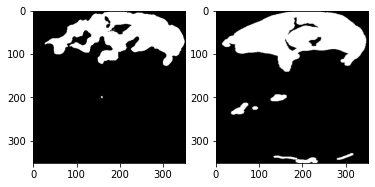


Epoch 00001: val_dice_coef improved from -inf to 0.73789, saving model to weights_save/unet.01_0.74.h5
12/12 [==============================] - 7s 608ms/step - loss: 0.1029 - accuracy: 0.9054 - dice_coef: 0.7243 - val_loss: 0.1051 - val_accuracy: 0.9176 - val_dice_coef: 0.7379
Epoch 2/80
12/12 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9134 - dice_coef: 0.7269------------------------
-------------------------


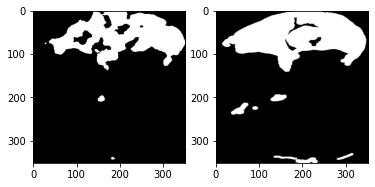


Epoch 00002: val_dice_coef did not improve from 0.73789
12/12 [==============================] - 6s 481ms/step - loss: 0.0958 - accuracy: 0.9134 - dice_coef: 0.7269 - val_loss: 0.1043 - val_accuracy: 0.9139 - val_dice_coef: 0.7368
Epoch 3/80
12/12 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9109 - dice_coef: 0.7182------------------------
-------------------------


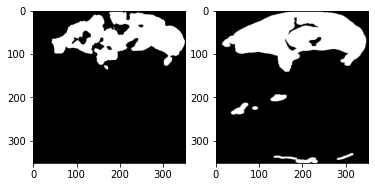


Epoch 00003: val_dice_coef did not improve from 0.73789
12/12 [==============================] - 6s 479ms/step - loss: 0.0957 - accuracy: 0.9109 - dice_coef: 0.7182 - val_loss: 0.1053 - val_accuracy: 0.9186 - val_dice_coef: 0.7364
Epoch 4/80
12/12 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9107 - dice_coef: 0.7333------------------------
-------------------------


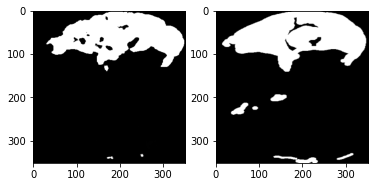


Epoch 00004: val_dice_coef did not improve from 0.73789
12/12 [==============================] - 6s 510ms/step - loss: 0.0906 - accuracy: 0.9107 - dice_coef: 0.7333 - val_loss: 0.1010 - val_accuracy: 0.9173 - val_dice_coef: 0.7347
Epoch 5/80
12/12 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9150 - dice_coef: 0.7303------------------------
-------------------------


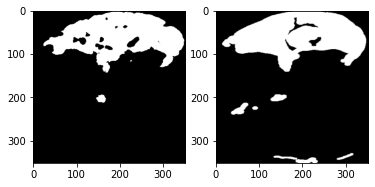


Epoch 00005: val_dice_coef improved from 0.73789 to 0.73802, saving model to weights_save/unet.05_0.74.h5
12/12 [==============================] - 6s 515ms/step - loss: 0.0880 - accuracy: 0.9150 - dice_coef: 0.7303 - val_loss: 0.1060 - val_accuracy: 0.9161 - val_dice_coef: 0.7380
Epoch 6/80
12/12 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9136 - dice_coef: 0.7295------------------------
-------------------------


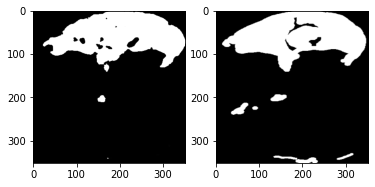


Epoch 00006: val_dice_coef improved from 0.73802 to 0.74668, saving model to weights_save/unet.06_0.75.h5
12/12 [==============================] - 6s 499ms/step - loss: 0.0932 - accuracy: 0.9136 - dice_coef: 0.7295 - val_loss: 0.1016 - val_accuracy: 0.9172 - val_dice_coef: 0.7467
Epoch 7/80
12/12 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9193 - dice_coef: 0.7414------------------------
-------------------------


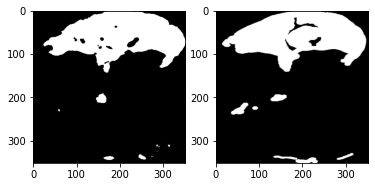


Epoch 00007: val_dice_coef did not improve from 0.74668
12/12 [==============================] - 6s 479ms/step - loss: 0.0845 - accuracy: 0.9193 - dice_coef: 0.7414 - val_loss: 0.0981 - val_accuracy: 0.9158 - val_dice_coef: 0.7427
Epoch 8/80
12/12 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9132 - dice_coef: 0.7205------------------------
-------------------------


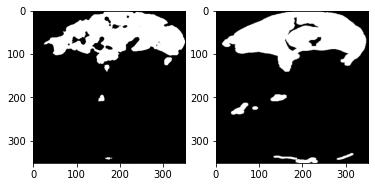


Epoch 00008: val_dice_coef did not improve from 0.74668
12/12 [==============================] - 6s 480ms/step - loss: 0.0913 - accuracy: 0.9132 - dice_coef: 0.7205 - val_loss: 0.1085 - val_accuracy: 0.9219 - val_dice_coef: 0.7344
Epoch 9/80
12/12 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9196 - dice_coef: 0.7544------------------------
-------------------------


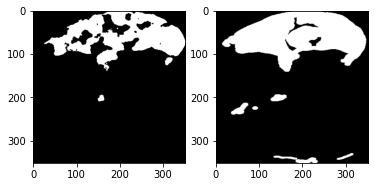


Epoch 00009: val_dice_coef did not improve from 0.74668
12/12 [==============================] - 6s 480ms/step - loss: 0.0808 - accuracy: 0.9196 - dice_coef: 0.7544 - val_loss: 0.1176 - val_accuracy: 0.9175 - val_dice_coef: 0.7082
Epoch 10/80
12/12 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9209 - dice_coef: 0.7414------------------------
-------------------------


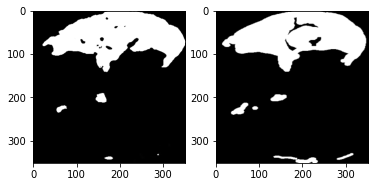


Epoch 00010: val_dice_coef improved from 0.74668 to 0.74908, saving model to weights_save/unet.10_0.75.h5
12/12 [==============================] - 6s 502ms/step - loss: 0.0837 - accuracy: 0.9209 - dice_coef: 0.7414 - val_loss: 0.0954 - val_accuracy: 0.9186 - val_dice_coef: 0.7491
Epoch 11/80
12/12 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9178 - dice_coef: 0.7673------------------------
-------------------------


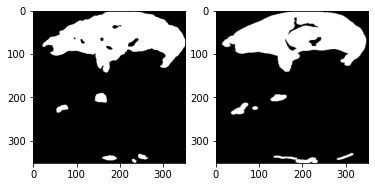


Epoch 00011: val_dice_coef did not improve from 0.74908
12/12 [==============================] - 6s 481ms/step - loss: 0.0842 - accuracy: 0.9178 - dice_coef: 0.7673 - val_loss: 0.0985 - val_accuracy: 0.9154 - val_dice_coef: 0.7378
Epoch 12/80
12/12 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9192 - dice_coef: 0.7599------------------------
-------------------------


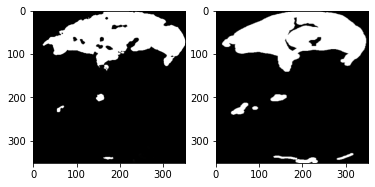


Epoch 00012: val_dice_coef did not improve from 0.74908
12/12 [==============================] - 6s 481ms/step - loss: 0.0806 - accuracy: 0.9192 - dice_coef: 0.7599 - val_loss: 0.0999 - val_accuracy: 0.9218 - val_dice_coef: 0.7431
Epoch 13/80
12/12 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9243 - dice_coef: 0.7861------------------------
-------------------------


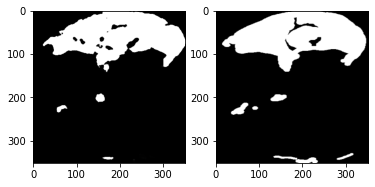


Epoch 00013: val_dice_coef did not improve from 0.74908
12/12 [==============================] - 6s 481ms/step - loss: 0.0699 - accuracy: 0.9243 - dice_coef: 0.7861 - val_loss: 0.1032 - val_accuracy: 0.9208 - val_dice_coef: 0.7436
Epoch 14/80
12/12 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9210 - dice_coef: 0.7825------------------------
-------------------------


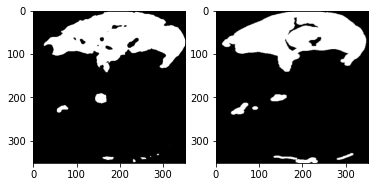


Epoch 00014: val_dice_coef did not improve from 0.74908
12/12 [==============================] - 6s 480ms/step - loss: 0.0773 - accuracy: 0.9210 - dice_coef: 0.7825 - val_loss: 0.0964 - val_accuracy: 0.9215 - val_dice_coef: 0.7465
Epoch 15/80
12/12 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9281 - dice_coef: 0.7751------------------------
-------------------------


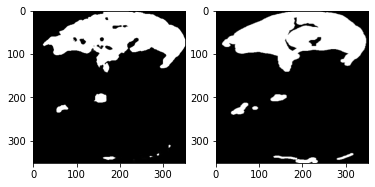


Epoch 00015: val_dice_coef improved from 0.74908 to 0.75325, saving model to weights_save/unet.15_0.75.h5
12/12 [==============================] - 6s 502ms/step - loss: 0.0699 - accuracy: 0.9281 - dice_coef: 0.7751 - val_loss: 0.0959 - val_accuracy: 0.9210 - val_dice_coef: 0.7533
Epoch 16/80
12/12 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9265 - dice_coef: 0.7646------------------------
-------------------------


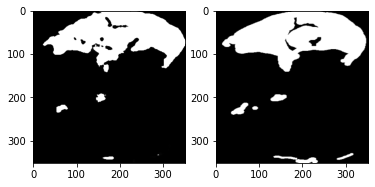


Epoch 00016: val_dice_coef did not improve from 0.75325
12/12 [==============================] - 6s 481ms/step - loss: 0.0735 - accuracy: 0.9265 - dice_coef: 0.7646 - val_loss: 0.1016 - val_accuracy: 0.9193 - val_dice_coef: 0.7467
Epoch 17/80
12/12 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9250 - dice_coef: 0.7823------------------------
-------------------------


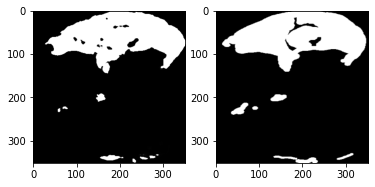


Epoch 00017: val_dice_coef did not improve from 0.75325
12/12 [==============================] - 6s 496ms/step - loss: 0.0695 - accuracy: 0.9250 - dice_coef: 0.7823 - val_loss: 0.1031 - val_accuracy: 0.9185 - val_dice_coef: 0.7413
Epoch 18/80
12/12 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9299 - dice_coef: 0.7740------------------------
-------------------------


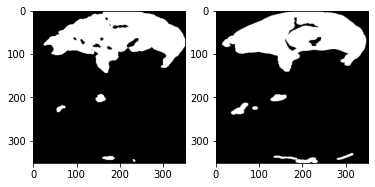


Epoch 00018: val_dice_coef did not improve from 0.75325
12/12 [==============================] - 6s 498ms/step - loss: 0.0708 - accuracy: 0.9299 - dice_coef: 0.7740 - val_loss: 0.1039 - val_accuracy: 0.9198 - val_dice_coef: 0.7457
Epoch 19/80
12/12 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9296 - dice_coef: 0.7807------------------------
-------------------------


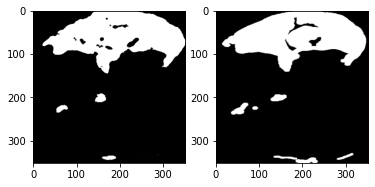


Epoch 00019: val_dice_coef did not improve from 0.75325
12/12 [==============================] - 6s 482ms/step - loss: 0.0677 - accuracy: 0.9296 - dice_coef: 0.7807 - val_loss: 0.0992 - val_accuracy: 0.9197 - val_dice_coef: 0.7498
Epoch 20/80
12/12 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9297 - dice_coef: 0.7794------------------------
-------------------------


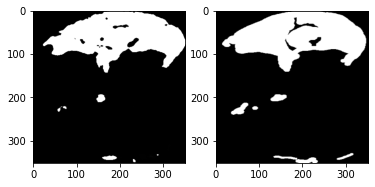


Epoch 00020: val_dice_coef did not improve from 0.75325
12/12 [==============================] - 6s 481ms/step - loss: 0.0655 - accuracy: 0.9297 - dice_coef: 0.7794 - val_loss: 0.1000 - val_accuracy: 0.9205 - val_dice_coef: 0.7526
Epoch 21/80
12/12 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9272 - dice_coef: 0.7878------------------------
-------------------------


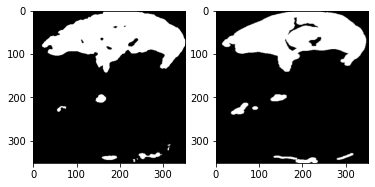


Epoch 00021: val_dice_coef improved from 0.75325 to 0.75681, saving model to weights_save/unet.21_0.76.h5
12/12 [==============================] - 6s 500ms/step - loss: 0.0702 - accuracy: 0.9272 - dice_coef: 0.7878 - val_loss: 0.0948 - val_accuracy: 0.9186 - val_dice_coef: 0.7568
Epoch 22/80
12/12 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9300 - dice_coef: 0.7917------------------------
-------------------------


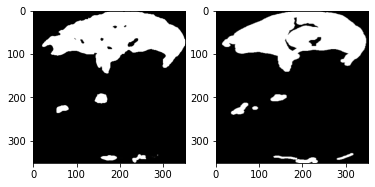


Epoch 00022: val_dice_coef improved from 0.75681 to 0.75725, saving model to weights_save/unet.22_0.76.h5
12/12 [==============================] - 6s 501ms/step - loss: 0.0665 - accuracy: 0.9300 - dice_coef: 0.7917 - val_loss: 0.0961 - val_accuracy: 0.9214 - val_dice_coef: 0.7573
Epoch 23/80
12/12 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9329 - dice_coef: 0.7880------------------------
-------------------------


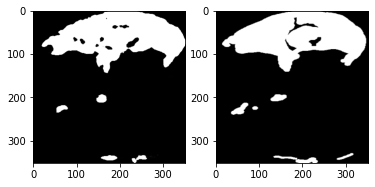


Epoch 00023: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 480ms/step - loss: 0.0613 - accuracy: 0.9329 - dice_coef: 0.7880 - val_loss: 0.1027 - val_accuracy: 0.9188 - val_dice_coef: 0.7465
Epoch 24/80
12/12 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9288 - dice_coef: 0.7879------------------------
-------------------------


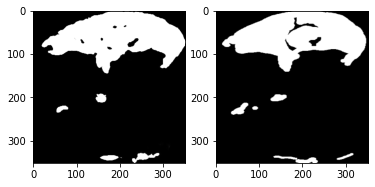


Epoch 00024: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 481ms/step - loss: 0.0678 - accuracy: 0.9288 - dice_coef: 0.7879 - val_loss: 0.0982 - val_accuracy: 0.9210 - val_dice_coef: 0.7529
Epoch 25/80
12/12 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9290 - dice_coef: 0.7855------------------------
-------------------------


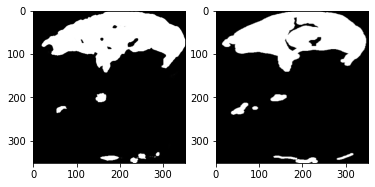


Epoch 00025: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 478ms/step - loss: 0.0672 - accuracy: 0.9290 - dice_coef: 0.7855 - val_loss: 0.0994 - val_accuracy: 0.9197 - val_dice_coef: 0.7514
Epoch 26/80
12/12 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9296 - dice_coef: 0.7964------------------------
-------------------------


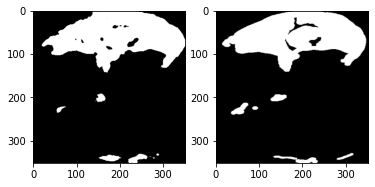


Epoch 00026: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 481ms/step - loss: 0.0639 - accuracy: 0.9296 - dice_coef: 0.7964 - val_loss: 0.1055 - val_accuracy: 0.9166 - val_dice_coef: 0.7472
Epoch 27/80
12/12 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9254 - dice_coef: 0.7900------------------------
-------------------------


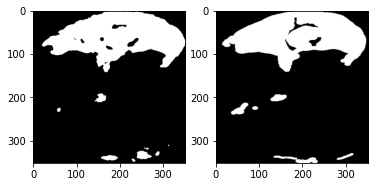


Epoch 00027: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 482ms/step - loss: 0.0697 - accuracy: 0.9254 - dice_coef: 0.7900 - val_loss: 0.0960 - val_accuracy: 0.9194 - val_dice_coef: 0.7458
Epoch 28/80
12/12 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9322 - dice_coef: 0.7923------------------------
-------------------------


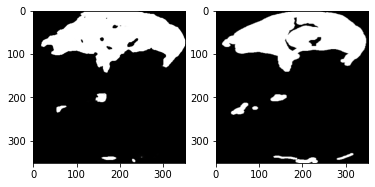


Epoch 00028: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 480ms/step - loss: 0.0645 - accuracy: 0.9322 - dice_coef: 0.7923 - val_loss: 0.1000 - val_accuracy: 0.9190 - val_dice_coef: 0.7549
Epoch 29/80
12/12 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9345 - dice_coef: 0.7974------------------------
-------------------------


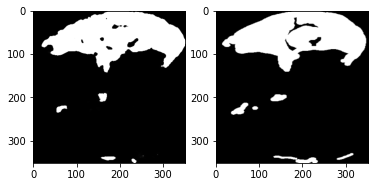


Epoch 00029: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 499ms/step - loss: 0.0600 - accuracy: 0.9345 - dice_coef: 0.7974 - val_loss: 0.1016 - val_accuracy: 0.9208 - val_dice_coef: 0.7486
Epoch 30/80
12/12 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9315 - dice_coef: 0.7951------------------------
-------------------------


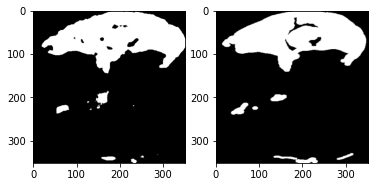


Epoch 00030: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 496ms/step - loss: 0.0622 - accuracy: 0.9315 - dice_coef: 0.7951 - val_loss: 0.1006 - val_accuracy: 0.9196 - val_dice_coef: 0.7521
Epoch 31/80
12/12 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9352 - dice_coef: 0.7896------------------------
-------------------------


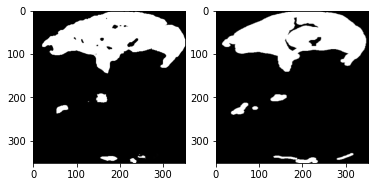


Epoch 00031: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 496ms/step - loss: 0.0596 - accuracy: 0.9352 - dice_coef: 0.7896 - val_loss: 0.0991 - val_accuracy: 0.9219 - val_dice_coef: 0.7544
Epoch 32/80
12/12 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9336 - dice_coef: 0.7887------------------------
-------------------------


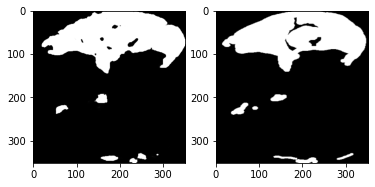


Epoch 00032: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0622 - accuracy: 0.9336 - dice_coef: 0.7887 - val_loss: 0.0950 - val_accuracy: 0.9217 - val_dice_coef: 0.7561
Epoch 33/80
12/12 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9340 - dice_coef: 0.7968------------------------
-------------------------


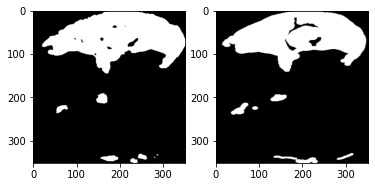


Epoch 00033: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0613 - accuracy: 0.9340 - dice_coef: 0.7968 - val_loss: 0.0985 - val_accuracy: 0.9154 - val_dice_coef: 0.7380
Epoch 34/80
12/12 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9305 - dice_coef: 0.7947------------------------
-------------------------


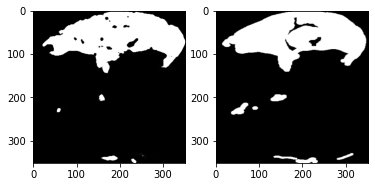


Epoch 00034: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0653 - accuracy: 0.9305 - dice_coef: 0.7947 - val_loss: 0.1026 - val_accuracy: 0.9194 - val_dice_coef: 0.7470
Epoch 35/80
12/12 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9306 - dice_coef: 0.8020------------------------
-------------------------


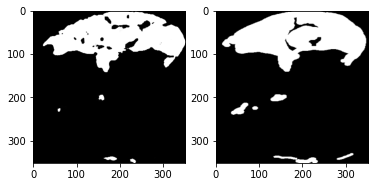


Epoch 00035: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0627 - accuracy: 0.9306 - dice_coef: 0.8020 - val_loss: 0.1204 - val_accuracy: 0.9140 - val_dice_coef: 0.7217
Epoch 36/80
12/12 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9313 - dice_coef: 0.7846------------------------
-------------------------


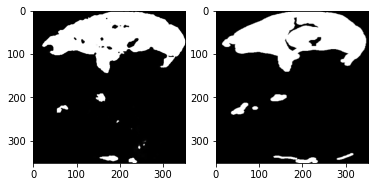


Epoch 00036: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0659 - accuracy: 0.9313 - dice_coef: 0.7846 - val_loss: 0.0972 - val_accuracy: 0.9183 - val_dice_coef: 0.7495
Epoch 37/80
12/12 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9216 - dice_coef: 0.7570------------------------
-------------------------


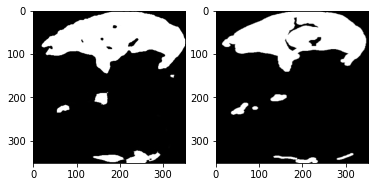


Epoch 00037: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 480ms/step - loss: 0.0754 - accuracy: 0.9216 - dice_coef: 0.7570 - val_loss: 0.1046 - val_accuracy: 0.9041 - val_dice_coef: 0.7129
Epoch 38/80
12/12 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9268 - dice_coef: 0.7809------------------------
-------------------------


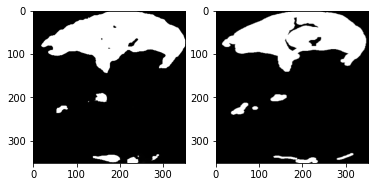


Epoch 00038: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0696 - accuracy: 0.9268 - dice_coef: 0.7809 - val_loss: 0.0969 - val_accuracy: 0.9141 - val_dice_coef: 0.7521
Epoch 39/80
12/12 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9248 - dice_coef: 0.7805------------------------
-------------------------


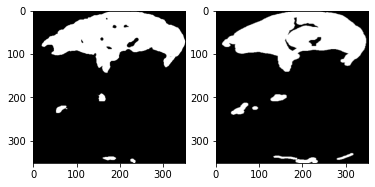


Epoch 00039: val_dice_coef did not improve from 0.75725
12/12 [==============================] - 6s 479ms/step - loss: 0.0689 - accuracy: 0.9248 - dice_coef: 0.7805 - val_loss: 0.1086 - val_accuracy: 0.9205 - val_dice_coef: 0.7379
Epoch 40/80
12/12 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9278 - dice_coef: 0.7927------------------------
-------------------------


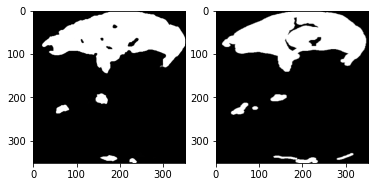


Epoch 00040: val_dice_coef improved from 0.75725 to 0.75964, saving model to weights_save/unet.40_0.76.h5
12/12 [==============================] - 6s 503ms/step - loss: 0.0649 - accuracy: 0.9278 - dice_coef: 0.7927 - val_loss: 0.0960 - val_accuracy: 0.9230 - val_dice_coef: 0.7596
Epoch 41/80
12/12 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9344 - dice_coef: 0.8000------------------------
-------------------------


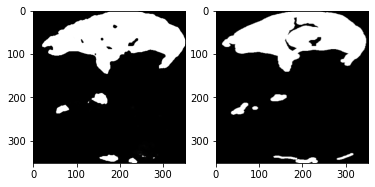


Epoch 00041: val_dice_coef did not improve from 0.75964
12/12 [==============================] - 6s 481ms/step - loss: 0.0612 - accuracy: 0.9344 - dice_coef: 0.8000 - val_loss: 0.0962 - val_accuracy: 0.9154 - val_dice_coef: 0.7512
Epoch 42/80
12/12 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9339 - dice_coef: 0.7915------------------------
-------------------------


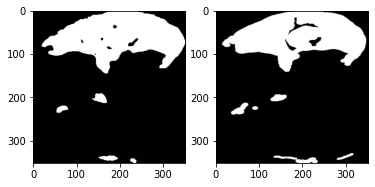


Epoch 00042: val_dice_coef did not improve from 0.75964
12/12 [==============================] - 6s 480ms/step - loss: 0.0626 - accuracy: 0.9339 - dice_coef: 0.7915 - val_loss: 0.0980 - val_accuracy: 0.9179 - val_dice_coef: 0.7577
Epoch 43/80
12/12 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9320 - dice_coef: 0.8020------------------------
-------------------------


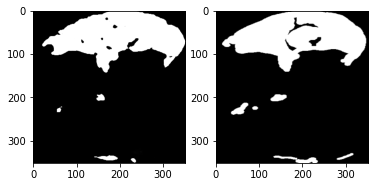


Epoch 00043: val_dice_coef did not improve from 0.75964
12/12 [==============================] - 6s 497ms/step - loss: 0.0601 - accuracy: 0.9320 - dice_coef: 0.8020 - val_loss: 0.1047 - val_accuracy: 0.9206 - val_dice_coef: 0.7409
Epoch 44/80
12/12 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9359 - dice_coef: 0.7944------------------------
-------------------------


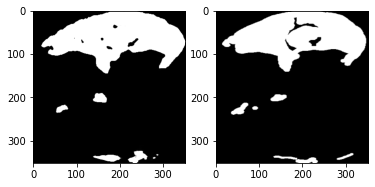


Epoch 00044: val_dice_coef did not improve from 0.75964
12/12 [==============================] - 6s 498ms/step - loss: 0.0601 - accuracy: 0.9359 - dice_coef: 0.7944 - val_loss: 0.0982 - val_accuracy: 0.9182 - val_dice_coef: 0.7485
Epoch 45/80
12/12 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9355 - dice_coef: 0.8042------------------------
-------------------------


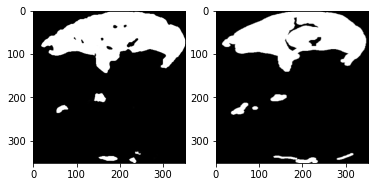


Epoch 00045: val_dice_coef did not improve from 0.75964
12/12 [==============================] - 6s 480ms/step - loss: 0.0577 - accuracy: 0.9355 - dice_coef: 0.8042 - val_loss: 0.0994 - val_accuracy: 0.9203 - val_dice_coef: 0.7568
Epoch 46/80
12/12 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9340 - dice_coef: 0.7957------------------------
-------------------------


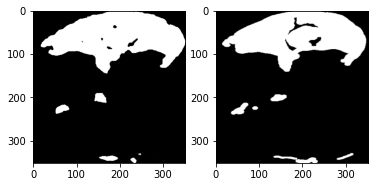


Epoch 00046: val_dice_coef improved from 0.75964 to 0.76026, saving model to weights_save/unet.46_0.76.h5
12/12 [==============================] - 6s 499ms/step - loss: 0.0592 - accuracy: 0.9340 - dice_coef: 0.7957 - val_loss: 0.0959 - val_accuracy: 0.9222 - val_dice_coef: 0.7603
Epoch 47/80
12/12 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9325 - dice_coef: 0.8028------------------------
-------------------------


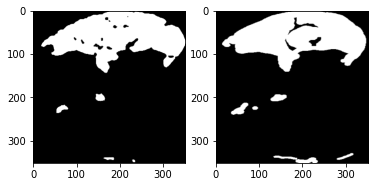


Epoch 00047: val_dice_coef did not improve from 0.76026
12/12 [==============================] - 6s 479ms/step - loss: 0.0615 - accuracy: 0.9325 - dice_coef: 0.8028 - val_loss: 0.1052 - val_accuracy: 0.9215 - val_dice_coef: 0.7445
Epoch 48/80
12/12 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9357 - dice_coef: 0.8072------------------------
-------------------------


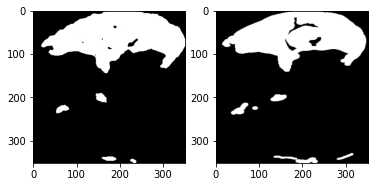


Epoch 00048: val_dice_coef improved from 0.76026 to 0.76160, saving model to weights_save/unet.48_0.76.h5
12/12 [==============================] - 6s 501ms/step - loss: 0.0571 - accuracy: 0.9357 - dice_coef: 0.8072 - val_loss: 0.0910 - val_accuracy: 0.9216 - val_dice_coef: 0.7616
Epoch 49/80
12/12 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9366 - dice_coef: 0.8038------------------------
-------------------------


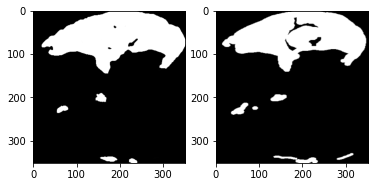


Epoch 00049: val_dice_coef improved from 0.76160 to 0.76486, saving model to weights_save/unet.49_0.76.h5
12/12 [==============================] - 6s 499ms/step - loss: 0.0579 - accuracy: 0.9366 - dice_coef: 0.8038 - val_loss: 0.0918 - val_accuracy: 0.9235 - val_dice_coef: 0.7649
Epoch 50/80
12/12 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9322 - dice_coef: 0.8080------------------------
-------------------------


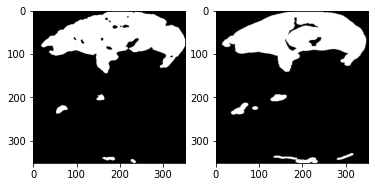


Epoch 00050: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0594 - accuracy: 0.9322 - dice_coef: 0.8080 - val_loss: 0.1084 - val_accuracy: 0.9187 - val_dice_coef: 0.7429
Epoch 51/80
12/12 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9333 - dice_coef: 0.8019------------------------
-------------------------


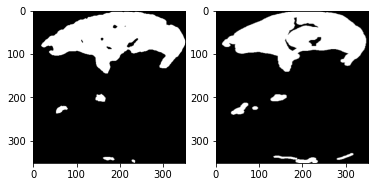


Epoch 00051: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 479ms/step - loss: 0.0599 - accuracy: 0.9333 - dice_coef: 0.8019 - val_loss: 0.0926 - val_accuracy: 0.9240 - val_dice_coef: 0.7594
Epoch 52/80
12/12 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9349 - dice_coef: 0.8089------------------------
-------------------------


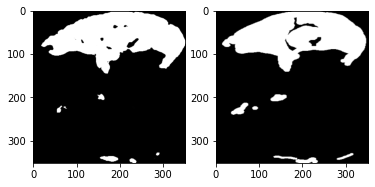


Epoch 00052: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 481ms/step - loss: 0.0589 - accuracy: 0.9349 - dice_coef: 0.8089 - val_loss: 0.0958 - val_accuracy: 0.9192 - val_dice_coef: 0.7539
Epoch 53/80
12/12 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9331 - dice_coef: 0.8104------------------------
-------------------------


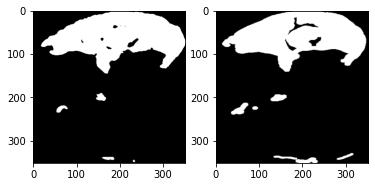


Epoch 00053: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 479ms/step - loss: 0.0598 - accuracy: 0.9331 - dice_coef: 0.8104 - val_loss: 0.0955 - val_accuracy: 0.9234 - val_dice_coef: 0.7571
Epoch 54/80
12/12 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9363 - dice_coef: 0.8072------------------------
-------------------------


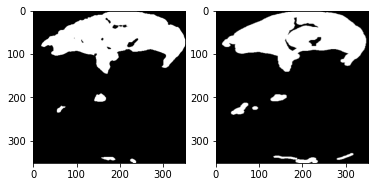


Epoch 00054: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 499ms/step - loss: 0.0559 - accuracy: 0.9363 - dice_coef: 0.8072 - val_loss: 0.1123 - val_accuracy: 0.9187 - val_dice_coef: 0.7307
Epoch 55/80
12/12 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9352 - dice_coef: 0.8000------------------------
-------------------------


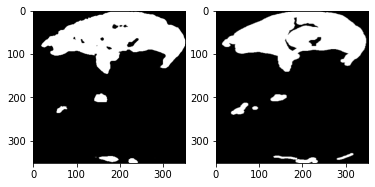


Epoch 00055: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 482ms/step - loss: 0.0567 - accuracy: 0.9352 - dice_coef: 0.8000 - val_loss: 0.1009 - val_accuracy: 0.9227 - val_dice_coef: 0.7521
Epoch 56/80
12/12 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9347 - dice_coef: 0.8017------------------------
-------------------------


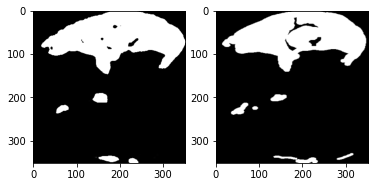


Epoch 00056: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 496ms/step - loss: 0.0606 - accuracy: 0.9347 - dice_coef: 0.8017 - val_loss: 0.0937 - val_accuracy: 0.9195 - val_dice_coef: 0.7519
Epoch 57/80
12/12 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9369 - dice_coef: 0.8076------------------------
-------------------------


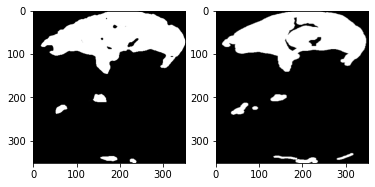


Epoch 00057: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 495ms/step - loss: 0.0564 - accuracy: 0.9369 - dice_coef: 0.8076 - val_loss: 0.0962 - val_accuracy: 0.9228 - val_dice_coef: 0.7565
Epoch 58/80
12/12 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9362 - dice_coef: 0.8107------------------------
-------------------------


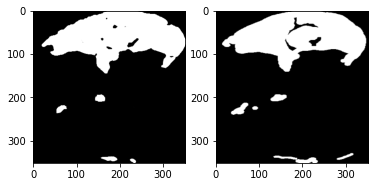


Epoch 00058: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 479ms/step - loss: 0.0560 - accuracy: 0.9362 - dice_coef: 0.8107 - val_loss: 0.0994 - val_accuracy: 0.9232 - val_dice_coef: 0.7510
Epoch 59/80
12/12 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9376 - dice_coef: 0.8141------------------------
-------------------------


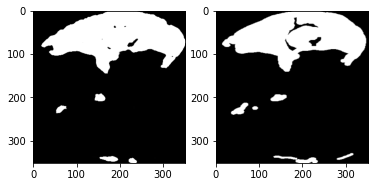


Epoch 00059: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 481ms/step - loss: 0.0529 - accuracy: 0.9376 - dice_coef: 0.8141 - val_loss: 0.0953 - val_accuracy: 0.9239 - val_dice_coef: 0.7567
Epoch 60/80
12/12 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9366 - dice_coef: 0.8190------------------------
-------------------------


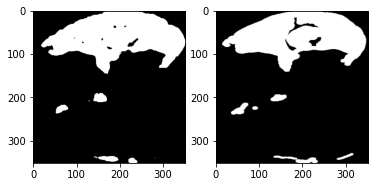


Epoch 00060: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 482ms/step - loss: 0.0560 - accuracy: 0.9366 - dice_coef: 0.8190 - val_loss: 0.0950 - val_accuracy: 0.9230 - val_dice_coef: 0.7628
Epoch 61/80
12/12 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9375 - dice_coef: 0.8180------------------------
-------------------------


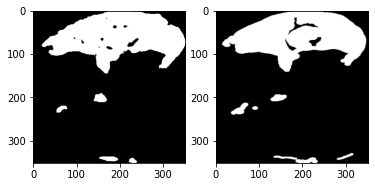


Epoch 00061: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0540 - accuracy: 0.9375 - dice_coef: 0.8180 - val_loss: 0.1000 - val_accuracy: 0.9214 - val_dice_coef: 0.7543
Epoch 62/80
12/12 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9390 - dice_coef: 0.8180------------------------
-------------------------


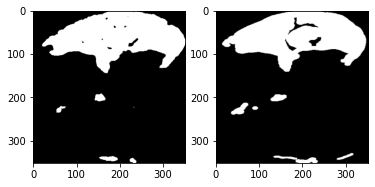


Epoch 00062: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0523 - accuracy: 0.9390 - dice_coef: 0.8180 - val_loss: 0.0965 - val_accuracy: 0.9236 - val_dice_coef: 0.7562
Epoch 63/80
12/12 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9352 - dice_coef: 0.8191------------------------
-------------------------


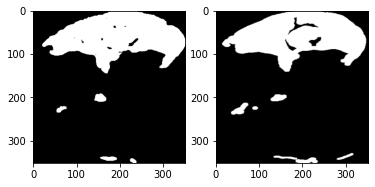


Epoch 00063: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0569 - accuracy: 0.9352 - dice_coef: 0.8191 - val_loss: 0.0970 - val_accuracy: 0.9250 - val_dice_coef: 0.7578
Epoch 64/80
12/12 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9376 - dice_coef: 0.8182------------------------
-------------------------


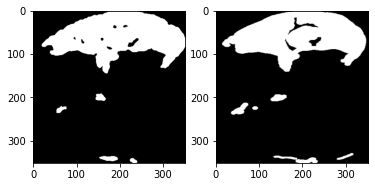


Epoch 00064: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0540 - accuracy: 0.9376 - dice_coef: 0.8182 - val_loss: 0.0995 - val_accuracy: 0.9196 - val_dice_coef: 0.7497
Epoch 65/80
12/12 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9369 - dice_coef: 0.8172------------------------
-------------------------


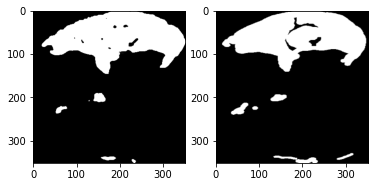


Epoch 00065: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0548 - accuracy: 0.9369 - dice_coef: 0.8172 - val_loss: 0.0950 - val_accuracy: 0.9242 - val_dice_coef: 0.7581
Epoch 66/80
12/12 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9347 - dice_coef: 0.8222------------------------
-------------------------


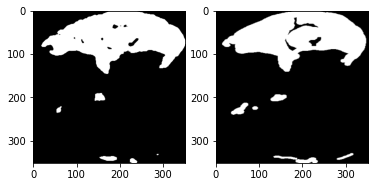


Epoch 00066: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0576 - accuracy: 0.9347 - dice_coef: 0.8222 - val_loss: 0.0998 - val_accuracy: 0.9208 - val_dice_coef: 0.7490
Epoch 67/80
12/12 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9394 - dice_coef: 0.8162------------------------
-------------------------


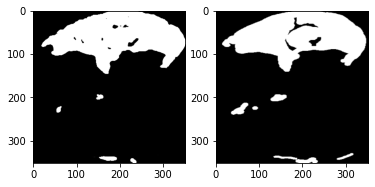


Epoch 00067: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 481ms/step - loss: 0.0525 - accuracy: 0.9394 - dice_coef: 0.8162 - val_loss: 0.1057 - val_accuracy: 0.9210 - val_dice_coef: 0.7481
Epoch 68/80
12/12 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9380 - dice_coef: 0.8126------------------------
-------------------------


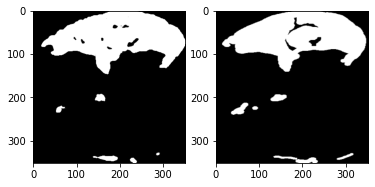


Epoch 00068: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0535 - accuracy: 0.9380 - dice_coef: 0.8126 - val_loss: 0.1043 - val_accuracy: 0.9210 - val_dice_coef: 0.7493
Epoch 69/80
12/12 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9378 - dice_coef: 0.8203------------------------
-------------------------


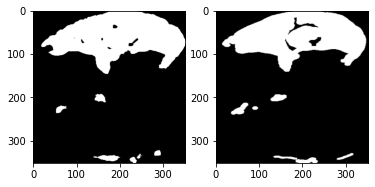


Epoch 00069: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 496ms/step - loss: 0.0538 - accuracy: 0.9378 - dice_coef: 0.8203 - val_loss: 0.0992 - val_accuracy: 0.9205 - val_dice_coef: 0.7537
Epoch 70/80
12/12 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9403 - dice_coef: 0.8182------------------------
-------------------------


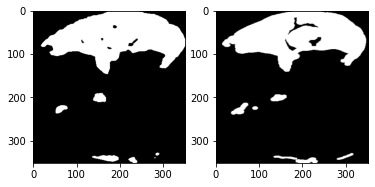


Epoch 00070: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 495ms/step - loss: 0.0521 - accuracy: 0.9403 - dice_coef: 0.8182 - val_loss: 0.0970 - val_accuracy: 0.9222 - val_dice_coef: 0.7597
Epoch 71/80
12/12 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9397 - dice_coef: 0.8223------------------------
-------------------------


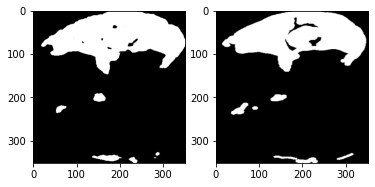


Epoch 00071: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0509 - accuracy: 0.9397 - dice_coef: 0.8223 - val_loss: 0.0942 - val_accuracy: 0.9236 - val_dice_coef: 0.7584
Epoch 72/80
12/12 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9391 - dice_coef: 0.8148------------------------
-------------------------


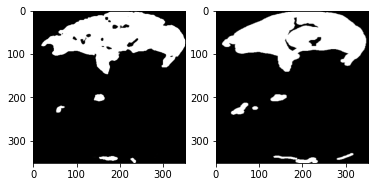


Epoch 00072: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 481ms/step - loss: 0.0519 - accuracy: 0.9391 - dice_coef: 0.8148 - val_loss: 0.1029 - val_accuracy: 0.9234 - val_dice_coef: 0.7431
Epoch 73/80
12/12 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9383 - dice_coef: 0.8223------------------------
-------------------------


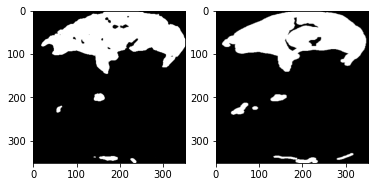


Epoch 00073: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0530 - accuracy: 0.9383 - dice_coef: 0.8223 - val_loss: 0.1024 - val_accuracy: 0.9217 - val_dice_coef: 0.7497
Epoch 74/80
12/12 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9392 - dice_coef: 0.8236------------------------
-------------------------


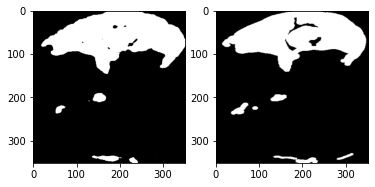


Epoch 00074: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 481ms/step - loss: 0.0522 - accuracy: 0.9392 - dice_coef: 0.8236 - val_loss: 0.0924 - val_accuracy: 0.9231 - val_dice_coef: 0.7633
Epoch 75/80
12/12 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9408 - dice_coef: 0.8238------------------------
-------------------------


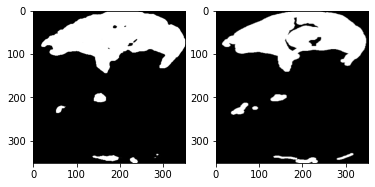


Epoch 00075: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 479ms/step - loss: 0.0513 - accuracy: 0.9408 - dice_coef: 0.8238 - val_loss: 0.0947 - val_accuracy: 0.9216 - val_dice_coef: 0.7606
Epoch 76/80
12/12 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9348 - dice_coef: 0.8242------------------------
-------------------------


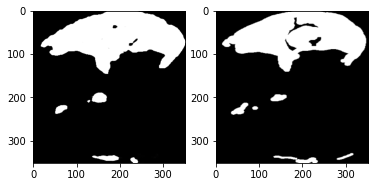


Epoch 00076: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 481ms/step - loss: 0.0557 - accuracy: 0.9348 - dice_coef: 0.8242 - val_loss: 0.0921 - val_accuracy: 0.9236 - val_dice_coef: 0.7626
Epoch 77/80
12/12 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9348 - dice_coef: 0.8090------------------------
-------------------------


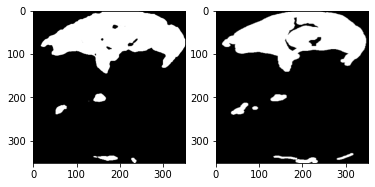


Epoch 00077: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0568 - accuracy: 0.9348 - dice_coef: 0.8090 - val_loss: 0.0984 - val_accuracy: 0.9239 - val_dice_coef: 0.7512
Epoch 78/80
12/12 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9335 - dice_coef: 0.8167------------------------
-------------------------


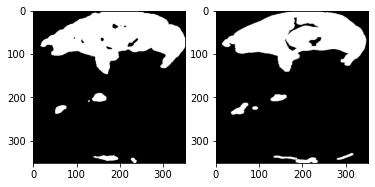


Epoch 00078: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 480ms/step - loss: 0.0566 - accuracy: 0.9335 - dice_coef: 0.8167 - val_loss: 0.1049 - val_accuracy: 0.9188 - val_dice_coef: 0.7481
Epoch 79/80
12/12 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9332 - dice_coef: 0.8114------------------------
-------------------------


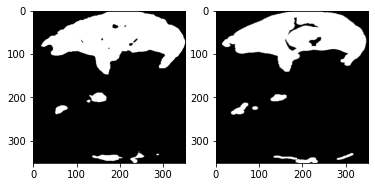


Epoch 00079: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 498ms/step - loss: 0.0591 - accuracy: 0.9332 - dice_coef: 0.8114 - val_loss: 0.0984 - val_accuracy: 0.9230 - val_dice_coef: 0.7514
Epoch 80/80
12/12 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9394 - dice_coef: 0.8113------------------------
-------------------------


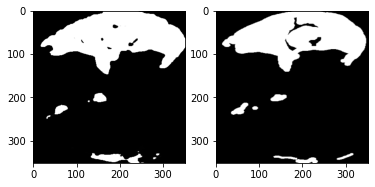


Epoch 00080: val_dice_coef did not improve from 0.76486
12/12 [==============================] - 6s 479ms/step - loss: 0.0522 - accuracy: 0.9394 - dice_coef: 0.8113 - val_loss: 0.1021 - val_accuracy: 0.9188 - val_dice_coef: 0.7509


In [19]:
input_shape = (h, w, 3)
img = imgs[:1]
mask = masks[:1]
#plt.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
#plt.show()
model = unet(input_shape,2,"/content/drive/My Drive/weight_infection_acl/unet.55_0.74.h5")
model.compile(optimizer = SGD(lr = 0.01, momentum = 0.9), loss = {"main_output":Active_Contour_Loss}, 
              metrics = {"main_output":['accuracy',dice_coef]})


checkpoint = ModelCheckpoint('weights_save/unet.{epoch:02d}_{val_dice_coef:.2f}.h5', 
                             monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
#lr_decay = lr_scheduler()
callback_list = [visualize(img,mask),checkpoint]
history = model.fit(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 80, 
                    validation_data = (img_dev, mask_dev),callbacks = callback_list,verbose = 1)

Ket qua
Dung ham heviside active contour loss

loss: 0.0579 - accuracy: 0.9366 - dice_coef: 0.8038 - val_loss: 0.0918 - val_accuracy: 0.9235 - val_dice_coef: 0.7649

#visualize 

In [ ]:
def dice_coef2(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    print(y_true_f.shape,y_pred_f.shape)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss2(y_true, y_pred):
    return 1-dice_coef2(y_true, y_pred)

In [ ]:
mask_pred = model.predict(img_dev)
#mask_pred = heviside(mask_pred)
mask_pred[mask_pred<0] = 0
mask_pred[mask_pred>0] = 1
print(dice_coef(mask_dev,mask_pred))
plt.imshow(mask_pred[1,:,:,0],cmap= 'gray')
plt.show()    
plt.imshow(mask_dev[1,:,:,0],cmap= 'gray')
plt.show()


In [ ]:
np.mean(np.sum(mask_dev[0]*mask_pred[0])*2/(np.sum(mask_dev[0])+np.sum(mask_pred[0])),axis = 0)

In [ ]:
model = unet(input_shape,2)
model.load_weights("weights_save/attention_unet.h5")

In [ ]:
model.summary()

In [ ]:
for count,layer in enumerate(model.layers):
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	print(count, layer.name)
	filters, biases = layer.get_weights()


In [ ]:
ixs = [2, 5, 9, 91, 94,97]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
pyplot.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
pyplot.show()
feature_maps = model.predict(imgs[:1,:,:,:])
# plot the output from each block
square = 2
for fmap in feature_maps:
    print(fmap.shape)
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            if ix > fmap.shape[-1]:
                continue
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
	# show the figure
    pyplot.show()

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
